# 0_overview_preparation.ipynb

# Simple Tutorial for Content-Aware Image Restoration (CARE)

# Use case: Restoration of low SNR 2D cell images



In this Tutorial we demonstrate how to use [CARE](http://csbdeep.bioimagecomputing.com/) for a simple 2D denoising task, where corresponding pairs of low and high signal-to-noise ratio (SNR) images of cells are available. 
The high SNR images are acquistions of Human U2OS cells taken from the [Broad Bioimage Benchmark Collection](https://data.broadinstitute.org/bbbc/BBBC006/) and the low SNR images were created by synthetically adding *strong read-out and shot-noise* and applying *pixel binning* of 2x2, thus mimicking acquisitions at a very low light level.   

![](imgs/denoising_binning_overview.png)

Each image pair should be registered, which in a real application setting is best achieved by acquiring both stacks _interleaved_, i.e. as different channels that correspond to the different exposure/laser settings. 

Since the image pairs were synthetically created in this example, they are already aligned perfectly.

### Download the data


In [ ]:
!wget http://idisk-srv1.mpi-cbg.de/~mweigert/snr_7_binning_2.zip

!unzip snr_7_binning_2.zip -d data

In [ ]:
!tree -L 2 -d data

In [ ]:
!tree data/train

# Workflow for a simple 2D denoising example

In general, a learned restoration pipeline will consist of the following 3 steps, which are thus split into 3 separate notebooks:


### 1. Generation of training data 

* [1_datagen.ipynb](1_datagen.ipynb)

### 2. Training of a restoration model 

* [2_training.ipynb](2_training.ipynb)
    
### 3. Prediction/Evaluation on holhold-out test set 

* [3_prediction.ipynb](3_prediction.ipynb)

# Installation of dependencies


To facilitate the training data generation as well as construction and training of the different neural enetwork architectures, we will use **CSBDeep**, a Python library for 2D/3D content-aware image restorations with convolutional neural networks (CARE). 

![](imgs/logo.png)

This library provides for example:    
 
* predefined architectures (residual U-Nets)
* denoising, isotropic reconstruction, upsampling (2D/3D) workflows
* data preprocessing/training data generation (e.g. normalisation, sampling)
* tiled predictions
* Export of trained models to Fiji  

A full documentation can be found at  
http://csbdeep.bioimagecomputing.com/doc/

The following would install the package locally: 





In [ ]:
!pip install csbdeep

In [ ]:
import csbdeep


### We are done with setting up! 

# 1_datagen.ipynb

<hr style="height:2px;">

# Demo: Restoration of low SNR 2D cell images


The high SNR images are acquistions of Human U2OS cells taken from the [Broad Bioimage Benchmark Collection](https://data.broadinstitute.org/bbbc/BBBC006/) and the low SNR images were created by synthetically adding *strong read-out and shot-noise* and applying *pixel binning* of 2x2, thus mimicking acquisitions at a very low light level.  

![](imgs/denoising_binning_overview.png)

Each image pair should be registered, which in a real application setting is best achieved by acquiring both stacks _interleaved_, i.e. as different channels that correspond to the different exposure/laser settings. 

Since the image pairs were synthetically created in this example, they are already aligned perfectly.

First, we will import some python modules...

In [ ]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tifffile import imread
from csbdeep.utils import download_and_extract_zip_file, plot_some
from csbdeep.data import RawData, create_patches

<hr style="height:2px;">

# Example data

The example data consists of low-SNR and high-SNR 2D images of human U2OS cells.  
Note that `GT` stands for [ground truth](https://en.wikipedia.org/wiki/Ground_truth) and represents high signal-to-noise ratio (SNR) stacks.

In [ ]:
!tree -d data

As we can see, the data set is already split into a **train** and **test** set, each containing low SNR ("low") and corresponding high SNR ("GT") images.

We can plot some training images:

In [ ]:
y = imread('data/train/GT/img_0010.tif')
x = imread('data/train/low/img_0010.tif')
print('image size =', x.shape)

plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.imshow(x, cmap  ="magma")
plt.colorbar()
plt.title("low")
plt.subplot(1,2,2)
plt.imshow(y, cmap  ="magma")
plt.colorbar()
plt.title("high");

<hr style="height:2px;">

# Generate training data for CARE

We first need to create a `RawData` object, which defines how to get the pairs of low/high SNR stacks and the semantics of each axis (e.g. which one is considered a color channel, etc.).

Here we have two folders "low" and "GT", where corresponding low and high-SNR stacks are TIFF images with identical filenames.  
For this case, we can simply use `RawData.from_folder` and set `axes = 'YX'` to indicate the semantic order of the image axes (i.e. we have 2 dimensional images in standard xy layout). 

In [ ]:
raw_data = RawData.from_folder (
    basepath    = 'data/train',
    source_dirs = ['low'],
    target_dir  = 'GT',
    axes        = 'YX',
)

From corresponding stacks, the function `create_patches` will now generate lots of paired patches that will be used for training the CARE model later.

`create_patches` returns values `(X, Y, XY_axes)`.
By convention, the variable name `X` (or `x`) refers to an input variable for a machine learning model, whereas `Y` (or `y`) indicates an output variable.


As a general rule, use a *patch size* that is a power of two along all axis, or at least divisible by 8. For this example we will use patches of size (128x128).

An important aspect is *data normalization*, i.e. the rescaling of corresponding patches to a dynamic range of ~ (0,1). By default, this is automatically provided via percentile normalization, which can be adapted if needed. 

By default, patches are sampled from *non-background regions* i.e. that are above a relative threshold that can be given in the function below. We will disable this for the current example as most images region already contain foreground pixels and thus set the threshold to 0.  

In [ ]:
from csbdeep.data import no_background_patches, norm_percentiles, sample_percentiles

X, Y, XY_axes = create_patches (
    raw_data            = raw_data,
    patch_size          = (128,128),
    patch_filter        = no_background_patches(0),
    n_patches_per_image = 2,
    save_file           = 'data/my_training_data.npz',
)

In [ ]:
assert X.shape == Y.shape
print("shape of X,Y =", X.shape)
print("axes  of X,Y =", XY_axes)

## Show some example patches

This shows the some of the generated patch pairs (even rows: *input*, odd rows: *target*)

In [ ]:
for i in range(2):
    plt.figure(figsize=(16,4))
    sl = slice(8*i, 8*(i+1)), 0
    plot_some(X[sl],Y[sl],title_list=[np.arange(sl[0].start,sl[0].stop)])
    plt.show()
None;

# 2_training.ipynb

<hr style="height:2px;">

# Demo: Restoration of low SNR 2D cell images

This notebook demonstrates training a CARE model for a 2D denoising task, assuming that training data was already generated via [1_datagen.ipynb](1_datagen.ipynb) and has been saved to disk to the file ``data/my_training_data.npz``.

Note that training a neural network for actual use should be done on more (representative) data and with more training time.

More Documentation is available at http://csbdeep.bioimagecomputing.com/doc/.

In [ ]:
from __future__ import print_function, unicode_literals, absolute_import, division

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0" # or 1 or 2 or 3


import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from tifffile import imread
from csbdeep.utils import axes_dict, plot_some, plot_history
from csbdeep.utils.tf import limit_gpu_memory
from csbdeep.io import load_training_data
from csbdeep.models import Config, CARE

**Important**: As the TensorFlow backend uses all available GPU memory by default, please make sure that all other notebooks that used the GPU (e.g. training/prediction notebooks) are shut down before running this notebook. This can be done via the "Running" tab in the main "Home" notebook server page.

<hr style="height:2px;">

# Training and validation data

Here we load the data patches generated via [1_datagen.ipynb](1_datagen.ipynb), and split them into 90% actual training data and 10% *validation data*. The latter is used during model training as independent indicator of the restoration accuracy. Model performance on the training data is often better than on the validation data, in which case the model is *overfitting*. Monitoring the validation performance gives us a chance to detect that. 

In [ ]:
(X,Y), (X_val,Y_val), axes = load_training_data('data/my_training_data.npz', validation_split=0.1, verbose=True)

c = axes_dict(axes)['C']
n_channel_in, n_channel_out = X.shape[c], Y.shape[c]

In [ ]:
plt.figure(figsize=(12,5))
plot_some(X_val[:5],Y_val[:5])
plt.suptitle('5 example validation patches (top row: source, bottom row: target)');

<hr style="height:2px;">

# CARE model


Before we construct the actual CARE model, we have to define its configuration via a `Config` object, which includes 
* parameters of the underlying neural network (a rather small 2D U-Net with 2x max pooling),
* the learning rate,
* the number of parameter updates per epoch,
* the loss function, and
* whether the model is probabilistic or not.

![](imgs/carenet.png)

The defaults should be sensible in many cases, so a change should only be necessary if the training process fails.  

---

<span style="color:red">**Important**</span>: Note that for this notebook we use a very small number of update steps per epoch for immediate feedback, whereas this number should be increased considerably (e.g. `train_steps_per_epoch=400`) to obtain a well-trained model.

In [ ]:
config = Config(axes, n_channel_in, n_channel_out, train_batch_size=8, train_steps_per_epoch=200, train_epochs = 20)
print(config)
vars(config)

We now create a CARE model with the chosen configuration:

In [ ]:
model = CARE(config, 'my_model', basedir='models')

In [ ]:
model.keras_model.summary()

<hr style="height:2px;">

# Training

Training the model may take some time.

## You can monitor the progress during training with [TensorBoard](https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard) by starting it from the current working directory:

    $ tensorboard --logdir=. --reload-interval=2

Then connect to [http://localhost:6006/](http://localhost:6006/) with your browser.

## Alternatively, you can use the jupyter_tensorboard extension (should be activated).

In [ ]:
history = model.train(X,Y, validation_data=(X_val,Y_val))

Plot final training history (available in TensorBoard during training):

In [ ]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss'],['mse','val_mse','mae','val_mae']);

<hr style="height:2px;">

# Evaluation

Example results for validation images.

In [ ]:
plt.figure(figsize=(20,12))
_P = model.keras_model.predict(X_val[:5])
if config.probabilistic:
    _P = _P[...,:(_P.shape[-1]//2)]
plot_some(X_val[:5],Y_val[:5],_P,pmax=99.5)
plt.suptitle('5 example validation patches\n'      
             'top row: input (source),  '          
             'middle row: target (ground truth),  '
             'bottom row: predicted from source');

<hr style="height:2px;">

# Export model to be used with CSBDeep **Fiji** plugins and **KNIME** workflows

See https://github.com/CSBDeep/CSBDeep_website/wiki/Your-Model-in-Fiji for details.

In [ ]:
model.export_TF()

# Shutting down this notebook will relase GPU memory again...

# 3_prediction.ipynb

<hr style="height:2px;">

# Demo: Restoration of low SNR 2D cell images

 This notebook demonstrates applying a CARE model for a 2D denoising task, assuming that training was already completed via [2_training.ipynb](2_training.ipynb).  
The trained model is assumed to be located in the folder `models` with the name `my_model`.

More Documentation is available at http://csbdeep.bioimagecomputing.com/doc/.

In [6]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tifffile import imread
from csbdeep.utils import Path, download_and_extract_zip_file, plot_some
from csbdeep.io import save_tiff_imagej_compatible
from csbdeep.models import CARE

<hr style="height:2px;">

# Raw low-SNR image and associated high-SNR ground truth

Plot the test image (with associated ground truth) and define its image axes, which will be needed later for CARE prediction.

image size = (256, 256)
image axes = YX


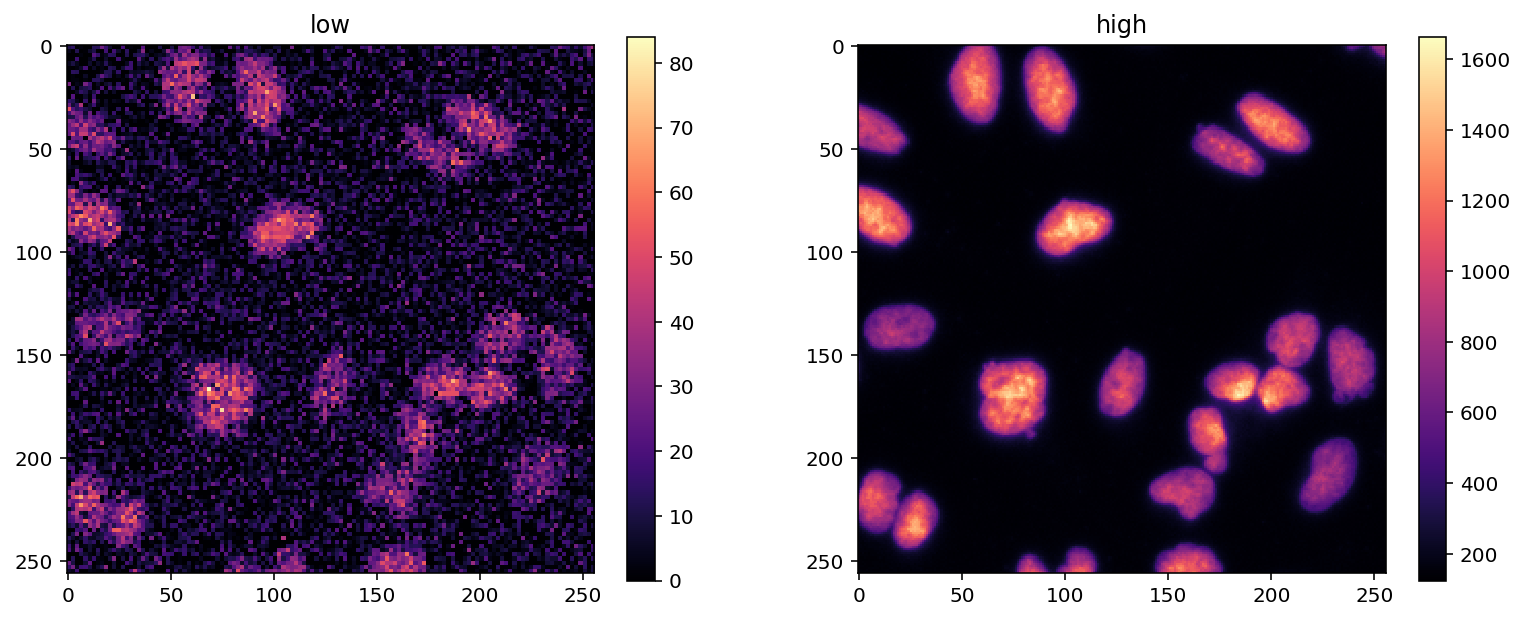

In [7]:
y = imread('data/test/GT/img_0010.tif')
x = imread('data/test/low/img_0010.tif')

axes = 'YX'
print('image size =', x.shape)
print('image axes =', axes)


plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.imshow(x, cmap  ="magma")
plt.colorbar()
plt.title("low")
plt.subplot(1,2,2)
plt.imshow(y, cmap  ="magma")
plt.colorbar()
plt.title("high");


<hr style="height:2px;">

# CARE model

Load trained model (located in base directory `models` with name `my_model`) from disk.  
The configuration was saved during training and is automatically loaded when `CARE` is initialized with `config=None`.

In [8]:
model = CARE(config=None, name='my_model', basedir='models')

Loading network weights from 'weights_best.h5'.


## Apply CARE network to raw image

Predict the restored image (image will be successively split into smaller tiles if there are memory issues).

In [9]:
%%time
restored = model.predict(x, axes)

CPU times: user 108 ms, sys: 20 ms, total: 128 ms
Wall time: 121 ms


Alternatively, one can directly set `n_tiles` to an appropriate value to avoid the time overhead from multiply retries in case of memory issues.

<hr style="height:2px;">

# Raw low/high-SNR image and denoised image via CARE network

Plot the test image pair and the predicted restored image (middle).

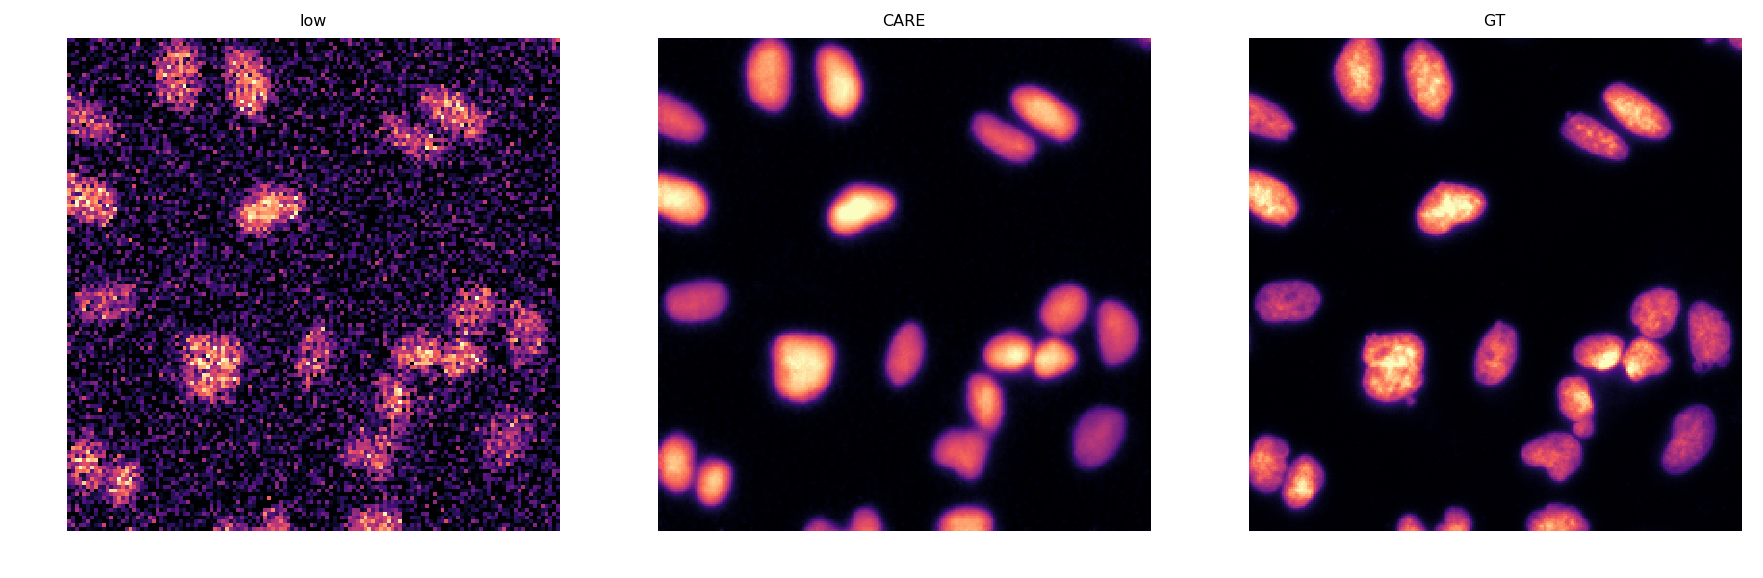

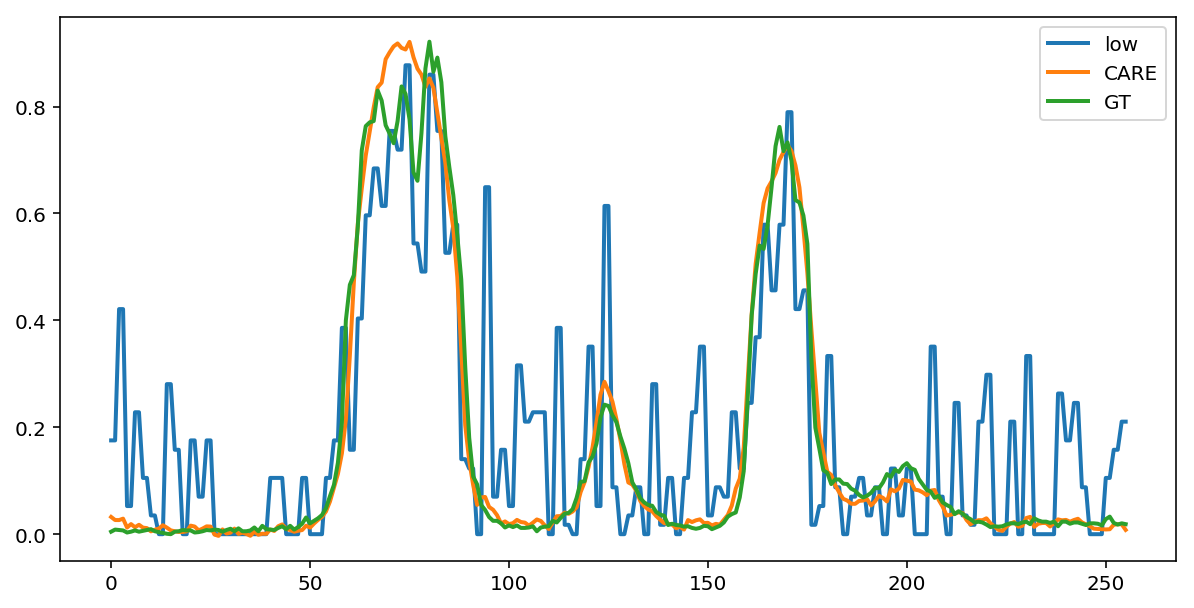

In [10]:
from csbdeep.utils import normalize



plt.figure(figsize=(15,10))
plot_some(np.stack([x,restored,y]),
          title_list=[['low','CARE','GT']], 
          pmin=2,pmax=99.8);

plt.figure(figsize=(10,5))
for _x,_name in zip((x,restored,y),('low','CARE','GT')):
    plt.plot(normalize(_x,1,99.7)[180], label = _name, lw = 2)
plt.legend();
